In [2]:
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import json
from pandas.io.json import json_normalize

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

## Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particulargeographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
# load as Pandas dataframe
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


We have 92,265 unique values and 93,142 entries --> therefore we have multiple logins at the same time.

In [6]:
logins['weekdays'] = logins.login_time.dt.weekday_name

In [7]:
#alternatively:
#logins['login_time'][0].strftime('%A')

In [8]:
df = logins.copy()
df['hour'] = logins.login_time.dt.hour
df['month'] = logins.login_time.dt.month
df['day'] = logins.login_time.dt.day
df['day of year'] = logins.login_time.dt.dayofyear
df['date'] = logins.login_time.dt.date
df['login'] = 1

In [9]:
df.groupby('month').sum()

,hour,day,day of year,login
month,,,,
1,242673,347988,347988,21239
2,289300,382066,1146929,24673
3,398105,547295,2536952,33723
4,153663,88842,1304472,13507


Ok, we do not have same amount of logins each month, so let's look whether we have same amount of data (=we have logs of each day of month, whole day).

In [10]:
df.groupby('date').sum().info()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 1970-01-01 to 1970-04-13
Data columns (total 5 columns):
hour           103 non-null int64
month          103 non-null int64
day            103 non-null int64
day of year    103 non-null int64
login          103 non-null int64
dtypes: int64(5)
memory usage: 4.8+ KB


We have data from the begining of the year until the mid April (1970-01-01 to 1970-04-13).

In [11]:
len(df['day of year'].unique())

103

According this result, we can assume we have atleast one entry for each day in our data set.

In [12]:
logins.head()

,login_time,weekdays
0,1970-01-01 20:13:18,Thursday
1,1970-01-01 20:16:10,Thursday
2,1970-01-01 20:16:37,Thursday
3,1970-01-01 20:16:36,Thursday
4,1970-01-01 20:26:21,Thursday


In [13]:
logins.set_index('login_time', inplace=True)
logins['login'] = 1

In [14]:
logins.head(10)

,weekdays,login
login_time,,
1970-01-01 20:13:18,Thursday,1
1970-01-01 20:16:10,Thursday,1
1970-01-01 20:16:37,Thursday,1
1970-01-01 20:16:36,Thursday,1
1970-01-01 20:26:21,Thursday,1
1970-01-01 20:21:41,Thursday,1
1970-01-01 20:12:16,Thursday,1
1970-01-01 20:35:47,Thursday,1
1970-01-01 20:35:38,Thursday,1


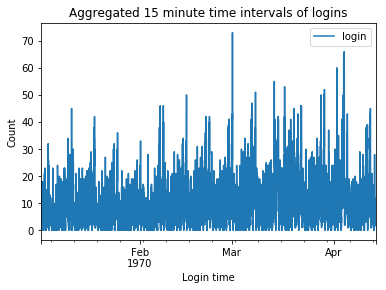

In [15]:
logins.resample('15T').sum().plot()
plt.ylabel('Count')
plt.xlabel('Login time')
plt.title('Aggregated 15 minute time intervals of logins')
plt.show()

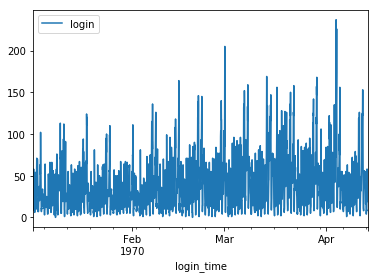

In [16]:
logins.resample('1H').sum().plot()

In [17]:
logins.head()

,weekdays,login
login_time,,
1970-01-01 20:13:18,Thursday,1
1970-01-01 20:16:10,Thursday,1
1970-01-01 20:16:37,Thursday,1
1970-01-01 20:16:36,Thursday,1
1970-01-01 20:26:21,Thursday,1


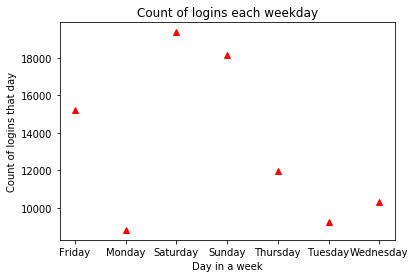

In [18]:
plt.plot(logins.groupby('weekdays').sum(), 'r^')
plt.xlabel('Day in a week')
plt.ylabel('Count of logins that day')
plt.title('Count of logins each weekday')
plt.show()

The most logins are during weekends and Fridays. hte lowest are on Mondays and Tuesdays. Now let's look how it looks a distributions of logins durign a day. We have chosen '1970-01-02' as it is a first day that have data on loginf through the whole day.

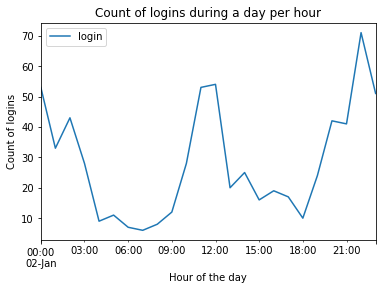

In [19]:
logins.resample('1H').sum()['1970-01-02'].plot()
plt.xlabel('Hour of the day')
plt.ylabel('Count of logins')
plt.title('Count of logins during a day per hour')
plt.show()

In [20]:
df['login'] = 1
df.head()

,login_time,weekdays,hour,month,day,day of year,date,login
0,1970-01-01 20:13:18,Thursday,20,1,1,1,1970-01-01,1
1,1970-01-01 20:16:10,Thursday,20,1,1,1,1970-01-01,1
2,1970-01-01 20:16:37,Thursday,20,1,1,1,1970-01-01,1
3,1970-01-01 20:16:36,Thursday,20,1,1,1,1970-01-01,1
4,1970-01-01 20:26:21,Thursday,20,1,1,1,1970-01-01,1


In [21]:
log_each_day = df.groupby('day of year').sum()
log_each_day.tail()

,hour,month,day,login
day of year,,,,
99,10661,3272,7362,818
100,13323,4036,10090,1009
101,15401,5408,14872,1352
102,12498,5636,16908,1409
103,3842,1580,5135,395


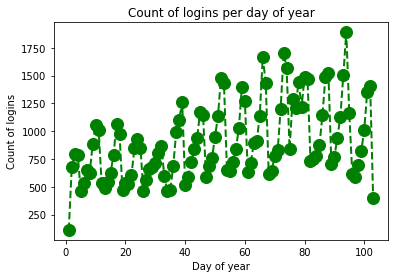

In [22]:
plt.plot(range(1,104), log_each_day['login'], 'go--', linewidth=2, markersize=12)
plt.xlabel('Day of year')
plt.ylabel('Count of logins')
plt.title("Count of logins per day of year")
plt.show()

We can definitely see previously observed phenomena - count og logging are higher during weekends, then suddenly drops and rise again. In addition, we can see that till March the count of logins were mostly frowing, however by the end of March till the late mid April was mostly dropping (notice one peak of growing at the March/April = 90th day).

## Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs. 
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:    
a. how you will implement the experiment   
b. what statistical test(s) you will conduct to verify the significance of the observation   
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.  


##### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
what we want to see is that drivers are not exclusive to one city. First of all, I would ask Ultimate managers how exclusive the drivers are = what are the ration fo spending time in city Gotham and Metropolis. I would discuss with them their expectations, whether they want to rise ratio of time spending in the other city eg from 5% to 50%. I focus na ratio of time spending in other city.
##### Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
###### a. how you will implement the experiment
I am assuming that being exclusive to one city means that drivers spend less than 5% of their time in the other city. Now question regarding where to set treshold for targeting ratio time spending in the other city: I don't think that ratio = 50% is reasonable as drivers probably live in one of the city and therefore they would still spent significant time in one city.
Here is discussion needed what is the aim of Ultimate managers. If we want just to increase this ratio, then we need to agree whether ratio = 20% is reasonable or it could be just ratio <= 5%.
###### b. what statistical test(s) you will conduct to verify the significance of the observation + c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.
A/B testing - given one (testing) group promotions of free toll week. Or 2 weeks, or even month - it is possible that during just one week we would not see "normal" habits that this promotion might bring. I assume during first week there would be peak of increase ratio - drivers would be excited to get to another city for free.  
Compare our test group with drivers who were paying for toll. We would see how ratio change as well and therefore decided whether it is good enough for Ultimate managers purposes.

## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).  

Data description
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYYMMDD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

In [23]:
# load json as a string
dataset = json.load((open('ultimate_data_challenge.json')))

In [24]:
# Look what's in dataset using json_normalize function, output is Pandas DataFrame
data = json_normalize(dataset)
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [25]:
data.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [27]:
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [28]:
data[['signup_date', 'last_trip_date']].describe()

,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18,2014-06-29
freq,2948,2036


In [29]:
print('Latest last trip:',data['last_trip_date'].max(), '\nEarliest last trip:',data['last_trip_date'].min()) 

Latest last trip: 2014-07-01 
Earliest last trip: 2014-01-01


In [30]:
type(data['last_trip_date'][0])

str

Convert all columns to numeric values - we will need later for modellins, earlier for heatmap as well.

In [31]:
#Convert the time series to datetimes appropriately
data.signup_date = pd.to_datetime(data.signup_date)
data.last_trip_date = pd.to_datetime(data.last_trip_date)
type(data['last_trip_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [32]:
data[data['last_trip_date'].dt.month == 7]['last_trip_date'].count()

548

In [33]:
# pd.get_dummies(data=data, columns=['phone', 'city'])
data['ultimate_black_user'] = data['ultimate_black_user'].astype(int)

In [34]:
data['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [35]:
data['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [36]:
data['city'].head(10)

0    King's Landing
1           Astapor
2           Astapor
3    King's Landing
4        Winterfell
5        Winterfell
6           Astapor
7        Winterfell
8        Winterfell
9        Winterfell
Name: city, dtype: object

In [37]:
data['phone'].head()

0     iPhone
1    Android
2     iPhone
3     iPhone
4    Android
Name: phone, dtype: object

In [38]:
# set categorical values of phone to 0 or 1
data['phone'] = data['phone'] == 'iPhone'
data['phone'] = data['phone'].astype(int)
# set categorical values of city to 1,2,3 using dictionary
d = {"King's Landing":3,'Astapor':1,'Winterfell':2,}
data['city'] = data['city'].replace(d)
data['city'].head()

0    3
1    1
2    1
3    3
4    2
Name: city, dtype: int64

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null int32
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
dtypes: datetime64[ns](2), float64(6), int32(2), int64(2)
memory usage: 4.2 MB


'city' is still object type, needs to be converted:

In [40]:
data['city'] = data['city'].astype(np.int64)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null int32
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
dtypes: datetime64[ns](2), float64(6), int32(2), int64(2)
memory usage: 4.2 MB


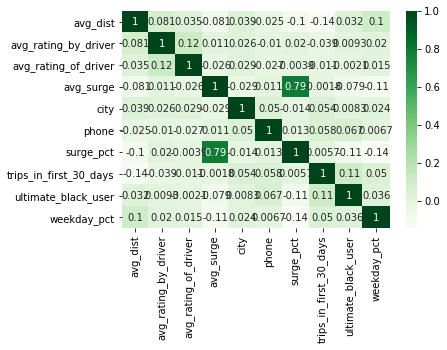

In [42]:
# Calculate correlations
corr = data.corr()
 
# Heatmap
sns.heatmap(corr, cmap="Greens", annot=True)
plt.show()

From the heatmap above we can see that avg_surge is correlated with surge_pct. Let's look what precisely these features mean:
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
Correlation here is no surprise - the more trips driver take the more probable is it would increase the percent of trips taken with surge multiplier > 1. 

In [43]:
data.columns


Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')

C:\Users\milen\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\milen\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


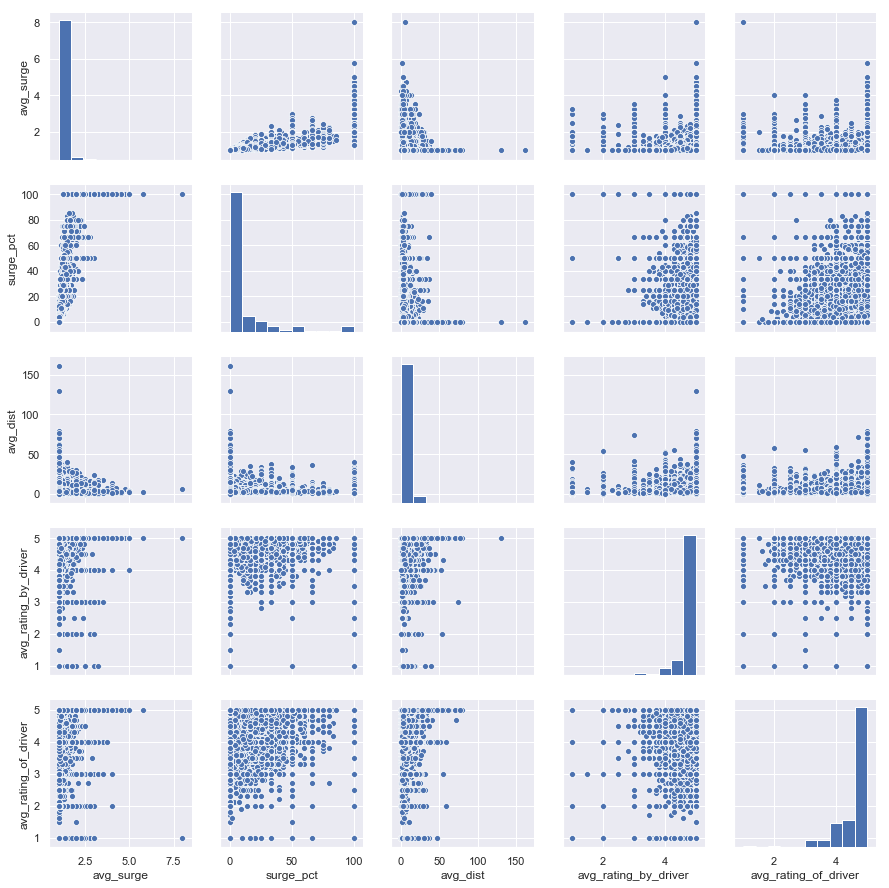

In [44]:
#scatterplot
sns.set() 
cols = ['avg_surge', 'surge_pct', 'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver']
sns.pairplot(data[cols])
plt.show()

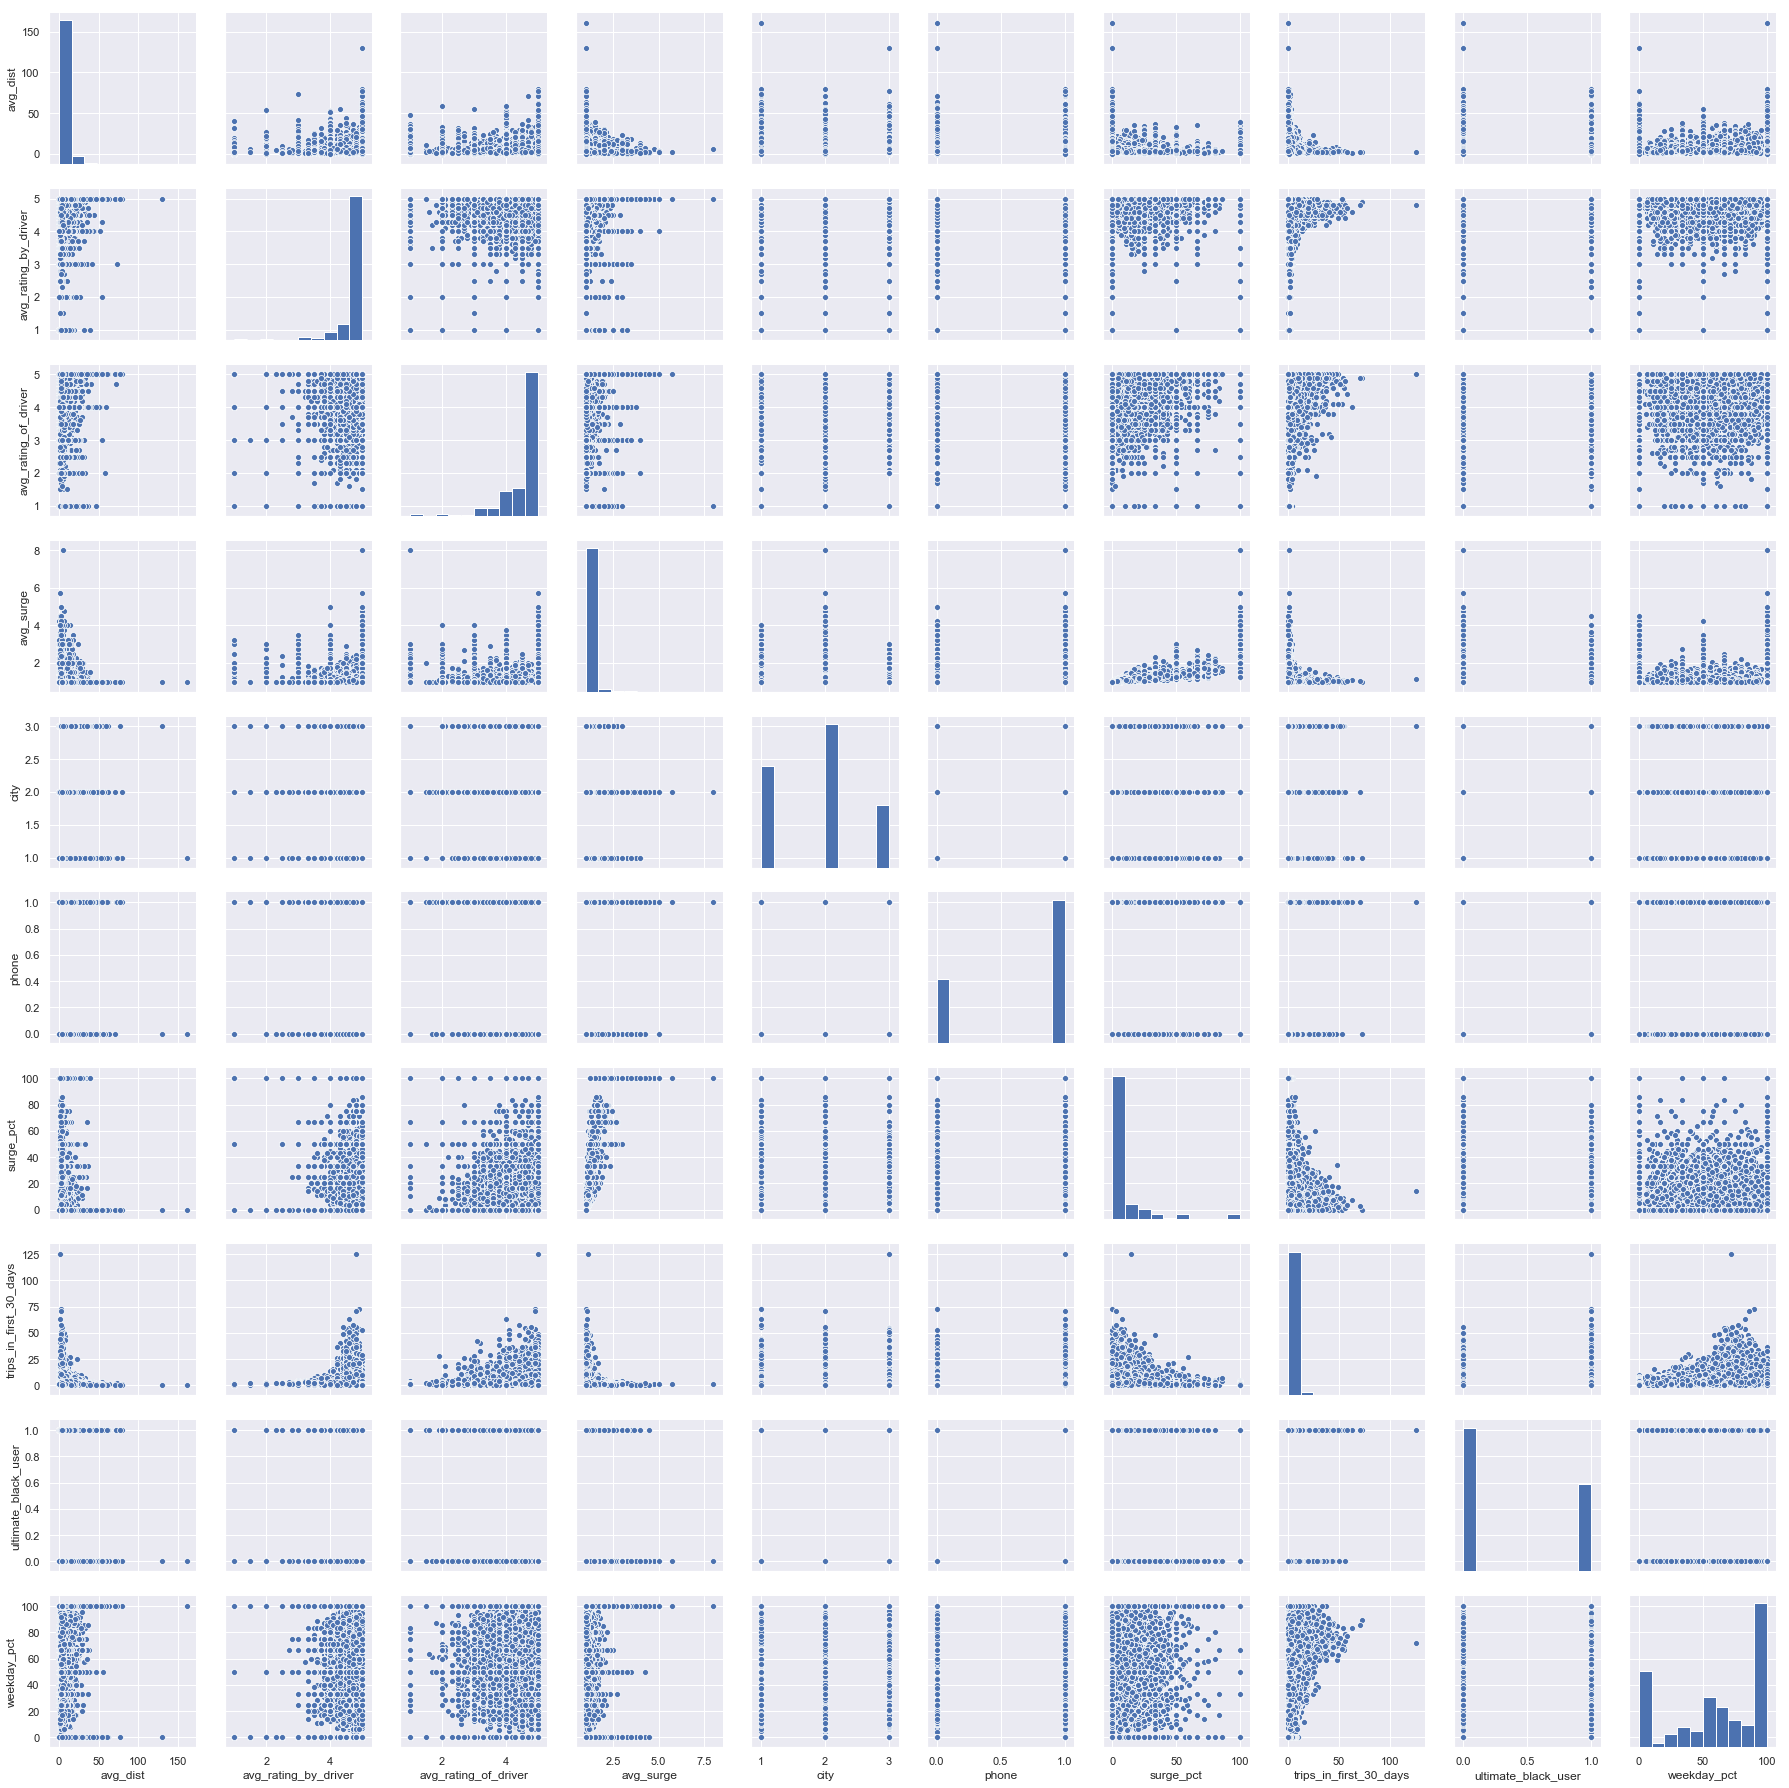

In [45]:
#scatterplot
sns.set() 
cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']
sns.pairplot(data[cols])
plt.show()

From the graphs above we can see we are dealing with not normally distributed data. Keep this in mind when creatin model - some models required normally distrubuted data as an input, others not.

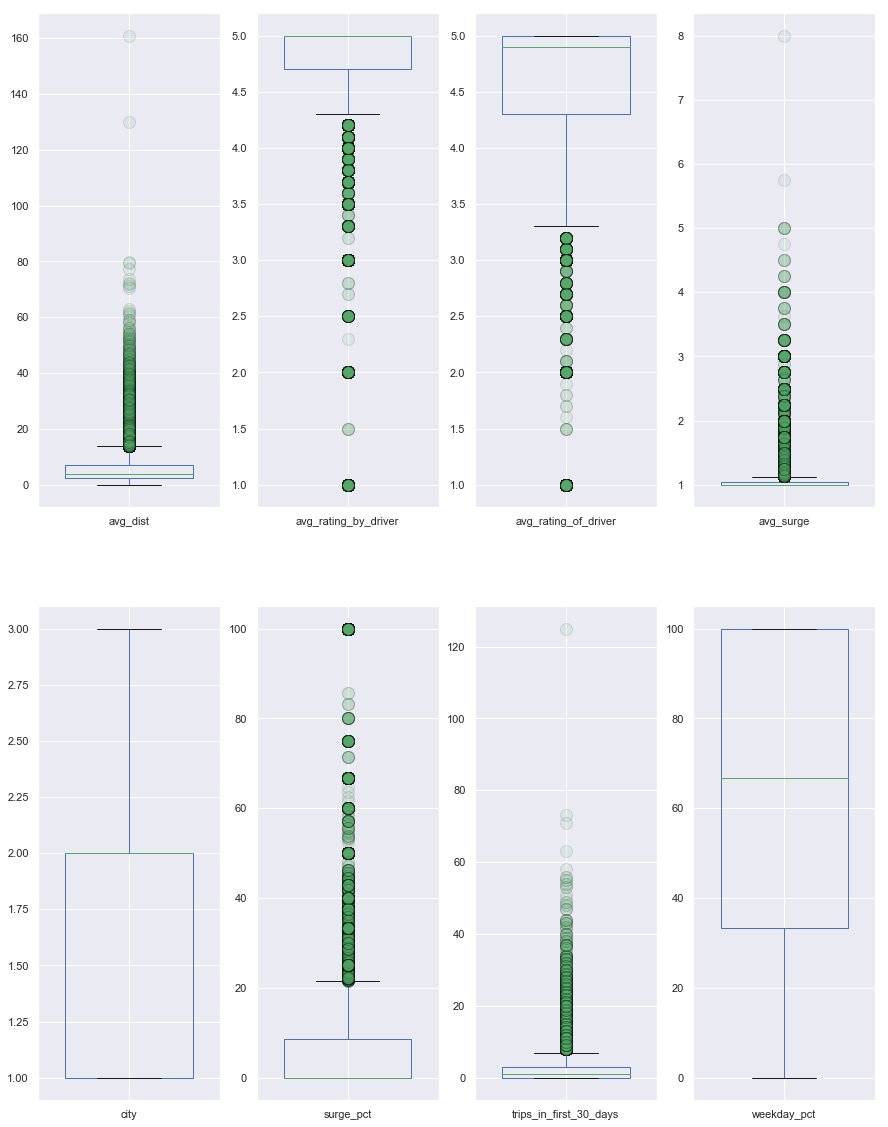

In [46]:
#Make subplotted figure
fig, axes = plt.subplots(2, 4, figsize=(15,20))

#Cycle through all relevant columns
i = 1
for col in data.select_dtypes(include=[np.float64, np.int64, np.bool]).columns:
    plt.subplot(2, 4, i)
    data[col].plot.box(widths=0.7, flierprops=dict(markerfacecolor='g', markersize=12, alpha=0.1), vert=True)
    i += 1
plt.show()

As we have highly skewed data, we expected result to have outliers like we can see in graphs above. The question is, whether we can get rid of this outliers (which are above four standard deviation), or should we keep them. In other words, we have to first find out whether we would delete a significant parcent of data if we get rid of outliers. Let's explore this.

In [47]:
def remove_outliers(df, col, num_sd=4.):
    return df[np.abs(df[col] - df[col].mean()) <= (num_sd * df[col].std())]

outlier_list = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 
                'trips_in_first_30_days']

for col in outlier_list:
    total = len(remove_outliers(data, col))
    print('%-25s : %i (%2.1f%%)' % (col, total, total*100./len(data)))

avg_dist                  : 49539 (99.1%)
avg_rating_by_driver      : 49451 (98.9%)
avg_rating_of_driver      : 41397 (82.8%)
avg_surge                 : 49272 (98.5%)
surge_pct                 : 48584 (97.2%)
trips_in_first_30_days    : 49441 (98.9%)


Keep in mind that in the case of 'avg_rating_of_driver' we can't get better percentage than 83.75, as we some missing data in given dataset.  
We don't loose too much information by removing this outliers, so let's do it.

In [48]:
clean_data = data.copy()
for col in outlier_list:
    clean_data = remove_outliers(clean_data, col)

clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39422 entries, 0 to 49998
Data columns (total 12 columns):
avg_dist                  39422 non-null float64
avg_rating_by_driver      39422 non-null float64
avg_rating_of_driver      39422 non-null float64
avg_surge                 39422 non-null float64
city                      39422 non-null int64
last_trip_date            39422 non-null datetime64[ns]
phone                     39422 non-null int32
signup_date               39422 non-null datetime64[ns]
surge_pct                 39422 non-null float64
trips_in_first_30_days    39422 non-null int64
ultimate_black_user       39422 non-null int32
weekday_pct               39422 non-null float64
dtypes: datetime64[ns](2), float64(6), int32(2), int64(2)
memory usage: 3.6 MB


We still have some NaN values we need to get rid of. 

In [49]:
clean_data.isnull().values.any()

False

All sign ups where done in January, so let's now create new feature which help us determine whether user is active or not. 0 declare the user is not activate, 1 if otherwise.  
Previously we found out:

In [50]:
print('Latest last trip:',clean_data['last_trip_date'].max(), '\nEarliest last trip:',clean_data['last_trip_date'].min()) 

Latest last trip: 2014-07-01 00:00:00 
Earliest last trip: 2014-01-01 00:00:00


And therfore active user are those who made trip during June or on 1st July.

In [51]:
f = clean_data['last_trip_date'].dt.month == 6
active = clean_data[f]['last_trip_date'].count()
print("There are %2.1f%% active users, for June." % (active/39422*100))
print(active)

There are 40.6% active users, for June.
16021


In [52]:
f2 = clean_data['last_trip_date'].dt.month == 7
active = clean_data[f2]['last_trip_date'].count()
print("There are %2.1f%% active users, for 1st July." % (active/39422*100))
print(active)

There are 1.3% active users, for 1st July.
502


In [53]:
clean_data['active user'] = f.astype(int) | f2.astype(int)
clean_data['active user'].head(10)

0     1
1     0
2     0
3     1
4     0
5     1
7     0
8     0
10    0
11    0
Name: active user, dtype: int32

In [54]:
clean_data[clean_data['active user'] == 1]['active user'].count()

16523

we have 16523 active users.

##### 2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
##### 3.Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [55]:
clean_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active user
0,3.67,5.0,4.7,1.10,3,2014-06-17,1,2014-01-25,15.4,4,1,46.2,1
1,8.26,5.0,5.0,1.00,1,2014-05-05,0,2014-01-29,0.0,0,0,50.0,0
2,0.77,5.0,4.3,1.00,1,2014-01-07,1,2014-01-06,0.0,3,0,100.0,0
3,2.36,4.9,4.6,1.14,3,2014-06-29,1,2014-01-10,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,2,2014-03-15,0,2014-01-27,11.8,14,0,82.4,0


In [56]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39422 entries, 0 to 49998
Data columns (total 13 columns):
avg_dist                  39422 non-null float64
avg_rating_by_driver      39422 non-null float64
avg_rating_of_driver      39422 non-null float64
avg_surge                 39422 non-null float64
city                      39422 non-null int64
last_trip_date            39422 non-null datetime64[ns]
phone                     39422 non-null int32
signup_date               39422 non-null datetime64[ns]
surge_pct                 39422 non-null float64
trips_in_first_30_days    39422 non-null int64
ultimate_black_user       39422 non-null int32
weekday_pct               39422 non-null float64
active user               39422 non-null int32
dtypes: datetime64[ns](2), float64(6), int32(3), int64(2)
memory usage: 3.8 MB


We do not need datetime columns anymore (information about active/inactive user is in our new feature 'active user').

In [57]:
clean_data.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [58]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39422 entries, 0 to 49998
Data columns (total 11 columns):
avg_dist                  39422 non-null float64
avg_rating_by_driver      39422 non-null float64
avg_rating_of_driver      39422 non-null float64
avg_surge                 39422 non-null float64
city                      39422 non-null int64
phone                     39422 non-null int32
surge_pct                 39422 non-null float64
trips_in_first_30_days    39422 non-null int64
ultimate_black_user       39422 non-null int32
weekday_pct               39422 non-null float64
active user               39422 non-null int32
dtypes: float64(6), int32(3), int64(2)
memory usage: 3.2 MB


We are dealing with binary classification problem. Therefore we try some basic classifiers for this kind of problem. Logistic regression, Random Forest. 

In [59]:
clean_data.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'phone', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct', 'active user'],
      dtype='object')

In [82]:
col = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'phone', 'surge_pct', 'trips_in_first_30_days',
       'ultimate_black_user', 'weekday_pct']
y = clean_data['active user'].values
x = clean_data[col].values
#Get the predictor variable columns
data_columns = clean_data[col].values

In [83]:
X_train,  X_test, y_train, y_test =  train_test_split(x, y, test_size=0.2, random_state=42)

In [84]:
print('The train data has %.0f rows which is %.2f%% of the total. ' % (len(X_train), len(X_train)*100./len(clean_data)))
print('The  test data has %.0f rows which is %.2f%% of the total. ' % (len(X_test),  len(X_test) *100./len(clean_data)))

The train data has 31537 rows which is 80.00% of the total. 
The  test data has 7885 rows which is 20.00% of the total. 


In [86]:
def train_logreg(X_train_sc, y_train, **kwargs):
    clf = LogisticRegression(random_state=0, 
                             class_weight='balanced',
                             solver=kwargs.get('solver', 'sag'), # instead of defaults you can have {} which would rise exception
                             penalty=kwargs.get('penalty', 'l2'), 
                             C=kwargs.get('C', 1.0))
    model = clf.fit(X_train_sc, y_train)
    return model 

def train_random(X_train_sc, y_train, **kwargs):
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', 
                                 bootstrap=kwargs.get('bootstrap', 'True'),
                                 n_estimators=kwargs.get('n_estimators', 100))
   
    model = clf.fit(X_train_sc, y_train)
    return model 


In [87]:
# Returns as pandas series, with multiple evaulation metrcis (fp, tn, fn, tp)
def eval_model(X_test_sc, y_test, X_train_sc, y_train):
    hp['f1_score'] = f1_score(y_test, model.predict(X_test_sc), average='weighted', labels=np.unique(model.predict(X_test_sc)))
    hp['recall'] = recall_score(y_test, model.predict(X_test_sc), average='weighted', labels=np.unique(model.predict(X_test_sc)))
    hp['precision'] = precision_score(y_test, model.predict(X_test_sc), average='weighted', labels=np.unique(model.predict(X_test_sc)))
    return hp

# Function updated_dict is helping us update dictionary of hyperparametrs for the classifier
def updated_dict(d, **kwargs):
    updated_d = d.copy()
    updated_d.update(kwargs)
    return updated_d

# Function clean_func_names gives us name of the classifier
def clean_func_names(df):
    df = df.copy()   
    columns = [c for c in df.columns if callable(df[c][0])] 
    for c in columns:
        funcs = []
        for train in df[c]:
            funcs.append(train.__name__)
        df[c] = funcs
    return df

In [88]:
scores = []
logreg_def_hyperpar = dict(train_function=train_logreg, solver='liblinear', penalty='l1', C=1.0)
RF_def_hyperpar = dict(train_function=train_random, bootstrap=True, n_estimators=100)

RF_hyperparameters =[RF_def_hyperpar, updated_dict(RF_def_hyperpar,bootstrap=False),
                    updated_dict(RF_def_hyperpar,n_estimators=1),
                     updated_dict(RF_def_hyperpar,n_estimators=1000),
                     updated_dict(RF_def_hyperpar,n_estimators=50),
                     updated_dict(RF_def_hyperpar,n_estimators=1000, bootstrap=False)
                    ]
logreg_hyperparameters = [logreg_def_hyperpar, updated_dict(logreg_def_hyperpar, C=0.5),
                         updated_dict(logreg_def_hyperpar, C=0.1),
                         updated_dict(logreg_def_hyperpar,solver='sag', penalty='l2'),
                         updated_dict(logreg_def_hyperpar, solver='sag', penalty='l2', C=0.5),
                         updated_dict(logreg_def_hyperpar,solver='sag', penalty='l2', C=0.1),
                         updated_dict(logreg_def_hyperpar,solver='newton-cg', penalty='l2'),
                         updated_dict(logreg_def_hyperpar,solver='newton-cg', penalty='l2', C=0.5),
                         updated_dict(logreg_def_hyperpar, solver='newton-cg', penalty='l2', C=0.1),
                         updated_dict(logreg_def_hyperpar,solver='lbfgs', penalty='l2'),  
                         updated_dict(logreg_def_hyperpar,solver='lbfgs', penalty='l2', C=0.5),
                          updated_dict(logreg_def_hyperpar,solver='lbfgs', penalty='l2', C=0.1)
                         ]

for hyperparameters in (logreg_hyperparameters + RF_hyperparameters):
    hp = logreg_def_hyperpar.copy()
    hp.update(hyperparameters)
    train = hp.get('train_function')
    print(hp)
    model = train(X_train, y_train, **hp)
    hp = eval_model(X_test, y_test, X_train, y_train)
    scores.append(hp)

{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}
{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 0.5}
{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'sag', 'penalty': 'l2', 'C': 1.0}
{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'sag', 'penalty': 'l2', 'C': 0.5}
{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'sag', 'penalty': 'l2', 'C': 0.1}
{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}
{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.5}
{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'newton-cg', '

C:\Users\milen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.5}


C:\Users\milen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'train_function': <function train_logreg at 0x000001A3DDA7C048>, 'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}


C:\Users\milen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'train_function': <function train_random at 0x000001A3DDA7C0D0>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0, 'bootstrap': True, 'n_estimators': 100}
{'train_function': <function train_random at 0x000001A3DDA7C0D0>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0, 'bootstrap': False, 'n_estimators': 100}
{'train_function': <function train_random at 0x000001A3DDA7C0D0>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0, 'bootstrap': True, 'n_estimators': 1}
{'train_function': <function train_random at 0x000001A3DDA7C0D0>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0, 'bootstrap': True, 'n_estimators': 1000}
{'train_function': <function train_random at 0x000001A3DDA7C0D0>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0, 'bootstrap': True, 'n_estimators': 50}
{'train_function': <function train_random at 0x000001A3DDA7C0D0>, 'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0, 'bootstrap': False, 'n_estimators': 1000}


In [101]:
df = clean_func_names(pd.DataFrame(scores))
df

,C,bootstrap,f1_score,n_estimators,penalty,precision,recall,solver,train_function
0,1.0,NaN,0.696424,NaN,l1,0.699331,0.695117,liblinear,train_logreg
1,0.5,NaN,0.696547,NaN,l1,0.699438,0.695244,liblinear,train_logreg
2,0.1,NaN,0.697592,NaN,l1,0.700636,0.696259,liblinear,train_logreg
3,1.0,NaN,0.696438,NaN,l2,0.699407,0.695117,sag,train_logreg
4,0.5,NaN,0.696438,NaN,l2,0.699407,0.695117,sag,train_logreg
5,0.1,NaN,0.696547,NaN,l2,0.699438,0.695244,sag,train_logreg
6,1.0,NaN,0.696799,NaN,l2,0.699690,0.695498,newton-cg,train_logreg
7,0.5,NaN,0.696670,NaN,l2,0.699545,0.695371,newton-cg,train_logreg
8,0.1,NaN,0.696533,NaN,l2,0.699363,0.695244,newton-cg,train_logreg
9,1.0,NaN,0.696827,NaN,l2,0.699842,0.695498,lbfgs,train_logreg


Our best classifier is Randon Forest and best performed row 16:  
C = 1   
bootstrap = True  
f1_score = 0.746084  
n_estimators = 50  
precision = 0.745744  
recall = 0.746861  
train_function = train_random  

In [90]:
rf_best = RandomForestClassifier(random_state=0, bootstrap=True, 
                                 class_weight='balanced', n_estimators=50)

rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In the end, let's take a look on the most important features:

In [95]:
pd.DataFrame(zip(clean_data.columns, rf_best.feature_importances_), columns=['Feature','Value']).\
   sort_values('Value', ascending=False).reset_index(drop=True)

,Feature,Value
0,avg_dist,0.283643
1,weekday_pct,0.141551
2,avg_rating_by_driver,0.118442
3,surge_pct,0.086802
4,trips_in_first_30_days,0.082530
5,city,0.079673
6,avg_rating_of_driver,0.077242
7,avg_surge,0.061369
8,phone,0.038392
9,ultimate_black_user,0.030356
